# Speech Self-Supervised Learning with wav2vec
Self-Supervised Learning (SSL) is a type of unsupervised learning (e.g. Language Models, etc.) -> It needs lots of data

Semi-Supervised Learning is a type of supervised learning lacking data with labels.

## Contrastive Learning
We create augmented data from the data we have (we know that these are in the same class), the aim is to increase intra-class distances and reduce inter-class distances.

### Import Required Libraries

In [ ]:
!pip install torchaudio pydub ipywidgets flashlight-text


In [24]:
import torch
import torchaudio
import torchaudio.pipelines
from pydub import AudioSegment
from IPython.display import Audio, display
import numpy as np
import io
import os
import base64
import ipywidgets as widgets
from IPython.display import display, Javascript
from torchaudio.models.decoder import ctc_decoder

### Load model and tokenizer

In [30]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()
labels = bundle.get_labels()

LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    lm=None,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

### Create a recording widget

In [ ]:
record_button = widgets.Button(description="Record")
stop_button = widgets.Button(description="Stop")
output = widgets.Output()

display(record_button, stop_button, output)

record_script = """
const recordAudio = () =>
  new Promise(async resolve => {
    const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
    const mediaRecorder = new MediaRecorder(stream);
    const audioChunks = [];
    mediaRecorder.addEventListener("dataavailable", event => {
      audioChunks.push(event.data);
    });
    const start = () => mediaRecorder.start();
    const stop = () =>
      new Promise(resolve => {
        mediaRecorder.addEventListener("stop", () => {
          const audioBlob = new Blob(audioChunks);
          const audioUrl = URL.createObjectURL(audioBlob);
          const audio = new Audio(audioUrl);
          const play = () => audio.play();
          resolve({ audioBlob, audioUrl, play });
        });
        mediaRecorder.stop();
      });
    resolve({ start, stop });
  });

let recorder;
document.querySelector("button[description='Record']").onclick = async () => {
  recorder = await recordAudio();
  recorder.start();
};

document.querySelector("button[description='Stop']").onclick = async () => {
  const audio = await recorder.stop();
  const reader = new FileReader();
  reader.readAsDataURL(audio.audioBlob);
  reader.onloadend = function() {
    var base64data = reader.result;
    google.colab.kernel.invokeFunction('notebook.record_audio', [base64data], {});
  };
};
"""

display(Javascript(record_script))

recorded_audio = None

def record_audio(base64_audio):
    global recorded_audio
    recorded_audio = base64_audio

from google.colab import output
output.register_callback('notebook.record_audio', record_audio)


### Upload Audio File

In [10]:
from google.colab import files

uploaded = files.upload()

audio_path = list(uploaded.keys())[0]
audio_path

Saving harvard.wav to harvard.wav


'harvard.wav'

### Process and Transcribe Audio

In [32]:
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

def decode_tokens(tokens, labels):
    transcription = ''
    for token in tokens:
        if token == labels.index('|'):
            transcription += ' '
        else:
            transcription += labels[token]
    return transcription

def transcribe(audio_path):
    waveform, sample_rate = load_audio(audio_path)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=bundle.sample_rate)(waveform)

    with torch.no_grad():
        emissions, _ = model(waveform)

    results = beam_search_decoder(emissions)
    best_result = results[0][0]

    transcription = decode_tokens(best_result.tokens, labels)
    return transcription

print("Transcribed text:", transcribe(audio_path))

Transcribed text:  THE STALE SMELL OF OLD BEER LINGERS IT TAKES HEAT TO BRING OUT THE ODOUR A COLD DIP RESTORES HEALTH AND ZEST A SALT PICKLE TASTES FINE WITH HAM TAKOZAL PASTOR ARE MY FAVORITE A ZESTFUL FOOD IS THE HOT CROSS BUN  


### Plot Audio Features

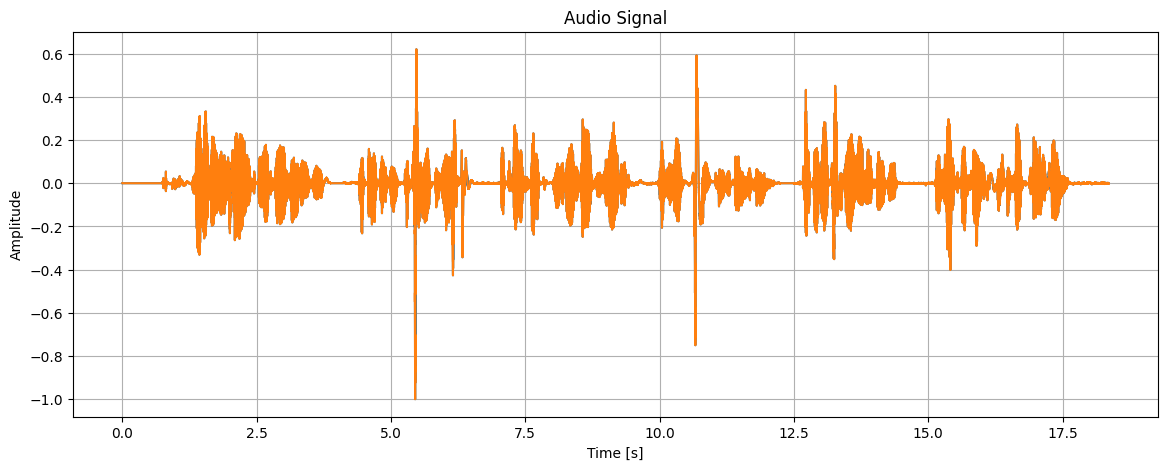

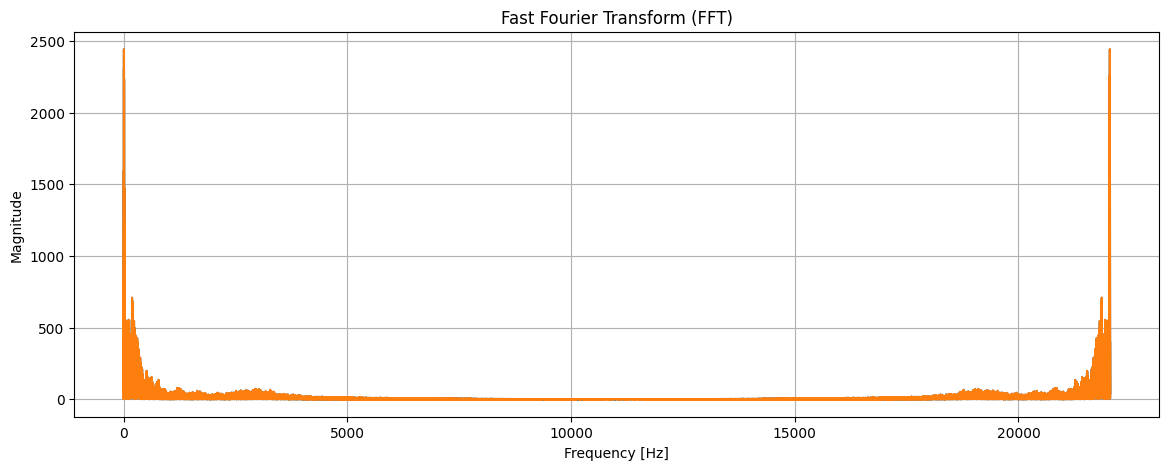

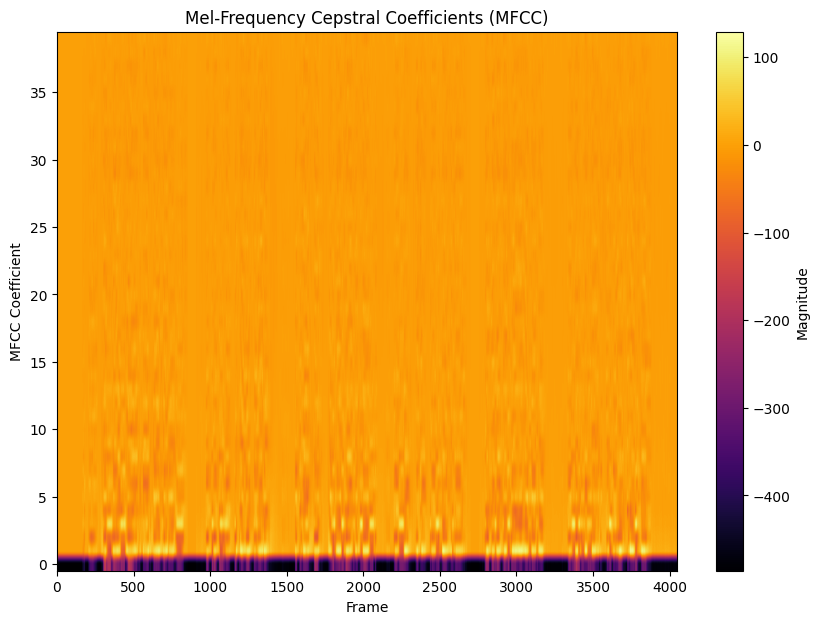

In [37]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T

def plot_audio_signal(waveform, sample_rate):
    duration = waveform.size(1) / sample_rate

    time_axis = torch.linspace(0, duration, steps=waveform.size(1))

    plt.figure(figsize=(14, 5))
    plt.plot(time_axis, waveform.t().numpy())
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.grid(True)
    plt.show()

def plot_fft(audio_signal, sample_rate):
    fft = torch.fft.fft(audio_signal)
    fft = torch.abs(fft)

    freq_axis = torch.linspace(0, sample_rate / 2, steps=fft.size(1))

    plt.figure(figsize=(14, 5))
    plt.plot(freq_axis, fft.t().numpy())
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Fast Fourier Transform (FFT)')
    plt.grid(True)
    plt.show()

def plot_mfcc(audio_signal, sample_rate):
    mfcc_transform = T.MFCC(sample_rate=sample_rate)
    mfcc = mfcc_transform(audio_signal)

    plt.figure(figsize=(10, 7))
    plt.imshow(mfcc[0].detach().numpy(), cmap='inferno', origin='lower', aspect='auto')
    plt.xlabel('Frame')
    plt.ylabel('MFCC Coefficient')
    plt.title('Mel-Frequency Cepstral Coefficients (MFCC)')
    plt.colorbar(label='Magnitude')
    plt.show()

waveform, sample_rate = load_audio(audio_path)
plot_audio_signal(waveform, sample_rate)
plot_fft(waveform, sample_rate)
plot_mfcc(waveform, sample_rate)